In [1]:
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import cv2 
import cv2 as cv
from tqdm import tqdm 
from celluloid import Camera

In [2]:
if gray.ndim == 2

SyntaxError: invalid syntax (<ipython-input-2-0ae8ba2f3266>, line 1)

In [148]:
def expand_dim_to_3(arr):
    if arr.ndim == 2:
        return np.expand_dims(arr, axis=-1)
    elif arr.ndim == 3:
        return arr
    else:
        raise ValueError()
        

def intensity_region_1(img, cx, cy, r, return_pixels=False):
    width = img.shape[0]
    height = img.shape[1]
    mask = np.zeros((width, height), np.uint8)

    circle_img = cv.circle(mask,(cx,cy),r, (255,255,255), thickness=-1)
    masked_data = cv.bitwise_and(img, img, mask=circle_img)[cy-r:cy+r+1, cx-r:cx+r+1]

    masked_data = expand_dim_to_3(masked_data)
    pixels = masked_data[masked_data.sum(axis=2)!=0]
    n_pixels = len(pixels)
    
#     print(np.trace(np.cov(pixels.T)))
    
#     mean_intensity = np.sum(np.max(masked_data, axis=-1)) / n_pixels
#     mean_intensity = np.sum(masked_data, axis=(0,1)) / n_pixels
    
    if return_pixels:
        return pixels 
    return pixels.mean(axis=0).mean(), n_pixels 
    
def intensity_region_2(img, cx, cy, r_in, r_out, return_pixels=False):

    assert r_in < r_out
    width = img.shape[0]
    height = img.shape[1]
    mask_r_out, mask_r_in = np.zeros((width, height), np.uint8), np.zeros((width, height), np.uint8)

    mask_r_out = cv.circle(mask_r_out,(cx,cy),r_out, (255,255,255), thickness=-1)
    mask_r_in = cv.circle(mask_r_in,(cx,cy),r_in, (255,255,255), thickness=-1)
    mask = cv.bitwise_and(mask_r_out, mask_r_out, mask=cv.bitwise_not(mask_r_in))
    
    masked_data = cv.bitwise_and(img, img, mask=mask)
    masked_data = expand_dim_to_3(masked_data)

    pixels = masked_data[masked_data.sum(axis=2)!=0]
    n_pixels = len(pixels)
    if return_pixels:
        return pixels 

#     mean_intensity = np.sum(np.max(masked_data, axis=-1)) / n_pixels
#     mean_intensity = np.sum(masked_data, axis=(0,1)) / n_pixels

    return pixels.mean(axis=0).mean(), n_pixels 


def seperability_filter(img, r_in, r_out):
    width, height = img.shape[:2]
    result = np.zeros((width, height))
    
    for x in tqdm(range(r_out, width-r_out)):
        for y in range(r_out, height-r_out):
#             I_in, n_in = intensity_region_1(img, x, y, r_in)
#             I_out, n_out = intensity_region_2(img, x, y, r_in, r_out) 
            
#             n_all = n_in + n_out
#             I_all = (n_in * I_in + n_out * I_out) / n_all
            
#             pixels = intensity_region_1(img, x, y, r_out, True)
#             mean_sum = np.sum([np.square(px - I_all) for px in pixels])
#             eta_dash = n_in * np.square((I_in - I_all)) + n_out * np.square((I_out - I_all)) / mean_sum
            
#             if I_in >= I_out:
#                 eta = eta_dash
#             else:
#                 eta = -eta_dash 
                            
#             result[x, y] = abs(eta)
            
            r1_pixels = intensity_region_1(img, x, y, r_in, True)
            r2_pixels = intensity_region_2(img, x, y, r_in, r_out, True)
            
            r1_mean = r1_pixels.mean(axis=0, keepdims=True).T
            r2_mean = r2_pixels.mean(axis=0, keepdims=True).T
            
            n_r1 = len(r1_pixels)
            n_r2 = len(r2_pixels)
            
            n_overall = n_r1 + n_r2
            overall_mean = r1_mean * n_r1/n_overall + r2_mean * n_r2/n_overall
                        
            S_B = n_overall * (r1_mean - overall_mean).dot((r1_mean - overall_mean).T) + \
                n_overall * (r2_mean - overall_mean).dot((r2_mean - overall_mean).T)
            
            
            S_T = np.cov(np.concatenate([r1_pixels, r2_pixels]).T)
            
#             print(r1_pixels.shape, r1_mean.shape, overall_mean.shape, S_B.shape)
#             print(r1_mean)
#             print(S_B)
#             print(cov.shape)
            
            if S_B.size==1:
                result[x,y] = S_B / S_T
            else:
                result[x,y] = np.trace(S_B) / np.trace(S_T)
                
    return result

100%|██████████| 43/43 [00:00<00:00, 52.72it/s]


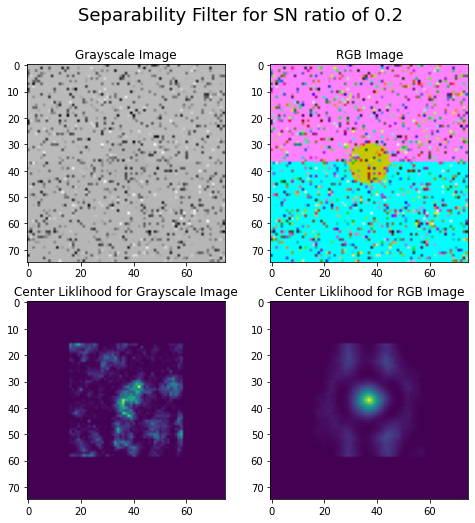

100%|██████████| 43/43 [00:00<00:00, 53.30it/s]


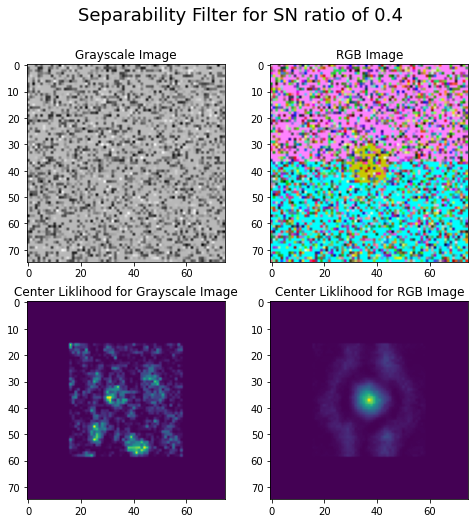

100%|██████████| 43/43 [00:00<00:00, 54.39it/s]


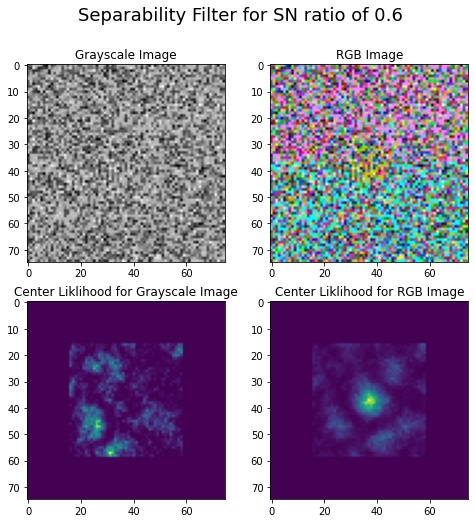

100%|██████████| 43/43 [00:00<00:00, 53.87it/s]


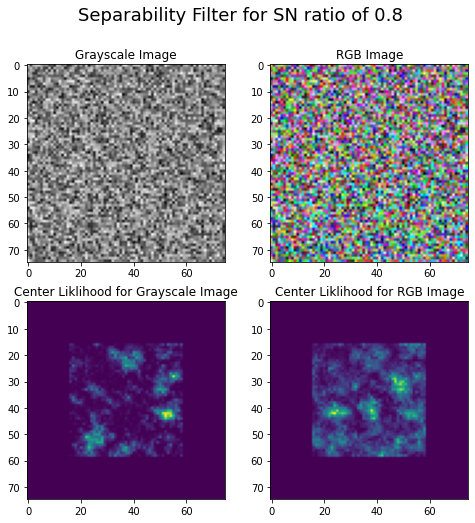

In [145]:
size = 75
dummy_im = np.zeros((size, size, 3), np.uint8)
dummy_im[:size//2] = (255,130,255)
dummy_im[size//2:] = (255,255,0)

cv.circle(dummy_im, (size//2, size//2), 8, (0,200,200), thickness=-1)

for density in [0.2, 0.4, 0.6, 0.8]:
    noise = np.ceil(scipy.sparse.rand(size, size, density).todense()).astype(np.uint8)
    dummy_im +=  np.random.randint(0, 255, size=(size,size,3), dtype=np.uint8) * np.expand_dims(noise, axis=-1)

    gray = cv2.cvtColor(dummy_im, cv2.COLOR_BGR2GRAY)
    rgb = cv2.cvtColor(dummy_im, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(2,2, figsize=(8,8))

    axs[0,0].imshow(gray, cmap='gray')
    axs[0,0].set_title('Grayscale Image')

    axs[0,1].imshow(rgb)
    axs[0,1].set_title('RGB Image')

    res = seperability_filter(gray, 8, 16)
    axs[1,0].imshow(res)
    axs[1,0].set_title('Center Liklihood for Grayscale Image')

    res = seperability_filter(rgb, 8, 16)
    axs[1,1].imshow(res)
    axs[1,1].set_title('Center Liklihood for RGB Image')

    fig.suptitle(f'Separability Filter for SN ratio of {density}', fontsize=18)
    plt.show()

100%|██████████| 43/43 [00:00<00:00, 84.86it/s]


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '576x288', '-pix_fmt', 'rgba', '-r', '600', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'animation.mp4']' returned non-zero exit status 255.

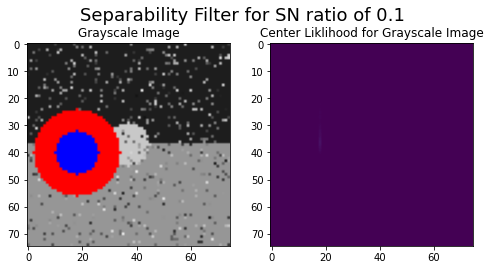

In [146]:
from itertools import product
from celluloid import Camera
from IPython.display import Video

size = 75
dummy_im = np.zeros((size, size, 3), np.uint8)
dummy_im[:size//2] = (255,0,0)
dummy_im[size//2:] = (0,255,0)
cv.circle(dummy_im, (size//2, size//2), 8, (200,200,200), thickness=-1)

density = 0.1

noise = np.ceil(scipy.sparse.rand(size, size, density).todense()).astype(np.uint8)
dummy_im +=  np.random.randint(0, 255, size=(size,size,3), dtype=np.uint8) * np.expand_dims(noise, axis=-1)

gray = cv2.cvtColor(dummy_im, cv2.COLOR_BGR2GRAY)
rgb = cv2.cvtColor(dummy_im, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1,2, figsize=(8,4))
res = seperability_filter(gray, 8, 16)
res_img = np.zeros(res.shape)
camera = Camera(fig)

frame = 0
for i, j in product(range(size), range(size)):
    if i < size // 4 or j < size // 4 or i > size * 3 //4 or j > size * 3 // 4:
        continue

    res_img[j, i] = res[j, i]

    gray_img = cv2.cvtColor(gray.copy(),cv2.COLOR_GRAY2BGR)
    cv.circle(gray_img, (i, j), 16, (255,0,0), thickness=-1)
    cv.circle(gray_img, (i, j), 8, (0,0,255), thickness=-1)

    axs[0].imshow(gray_img, cmap='gray')
    axs[0].set_title('Grayscale Image')


    axs[1].imshow(res_img, vmin=res.min(), vmax=res.max())
    axs[1].set_title('Center Liklihood for Grayscale Image')

    camera.snap()
    frame += 1
    
fig.suptitle(f'Separability Filter for SN ratio of {density}', fontsize=18)
animation = camera.animate()
animation.save('animation.mp4', fps=600)
Video('animation.mp4')

100%|██████████| 43/43 [00:00<00:00, 56.48it/s]


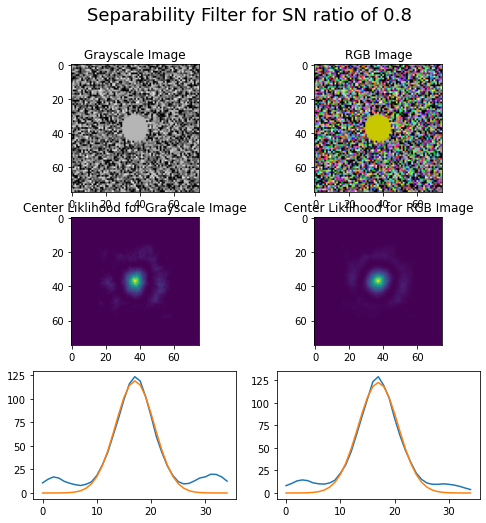

In [176]:
size = 75
dummy_im = np.zeros((size, size, 3), np.uint8)
density = 0.8

noise = np.ceil(scipy.sparse.rand(size, size, density).todense()).astype(np.uint8)
dummy_im +=  np.random.randint(0, 255, size=(size,size,3), dtype=np.uint8) * np.expand_dims(noise, axis=-1)
cv.circle(dummy_im, (size//2, size//2), 8, (0,200,200), thickness=-1)

gray = cv2.cvtColor(dummy_im, cv2.COLOR_BGR2GRAY)
rgb = cv2.cvtColor(dummy_im, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(3,2, figsize=(8,8))

axs[0,0].imshow(gray, cmap='gray')
axs[0,0].set_title('Grayscale Image')

axs[0,1].imshow(rgb)
axs[0,1].set_title('RGB Image')

res = seperability_filter(gray, 8, 16)
axs[1,0].imshow(res)
axs[1,0].set_title('Center Liklihood for Grayscale Image')

res = seperability_filter(rgb, 8, 16)
axs[1,1].imshow(res)
axs[1,1].set_title('Center Liklihood for RGB Image')


res = res[20:55, 20:55]
rx, ry = res.mean(axis=0), res.mean(axis=1)

cx, _ = curve_fit(gauss, range(20,55), rx, p0=[rx.argmax(), 35, rx.std()])
hx = gauss(range(20,55), *cx)
cy, _ = curve_fit(gauss, range(20,55), ry, p0=[ry.argmax(), 35, ry.std()])
hy = gauss(range(20,55), *cy)

axs[2,0].plot(rx)
axs[2,0].plot(hx)
axs[2,1].plot(ry)
axs[2,1].plot(hy)


fig.suptitle(f'Separability Filter for SN ratio of {density}', fontsize=18)
plt.show()

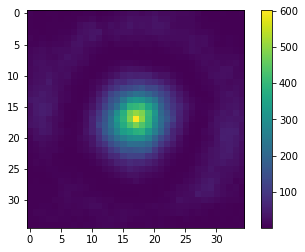

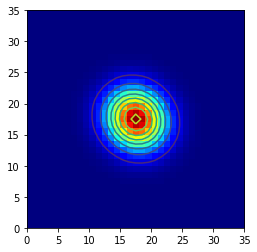

In [230]:
import scipy.optimize as opt
import numpy as np
import pylab as plt


def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

# Create x and y indices
size=35
x = np.linspace(0, size, size)
y = np.linspace(0, size, size)
x, y = np.meshgrid(x, y)

#create data
data = res.ravel()

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(size, size))
plt.colorbar()

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (1,size//2,size//2,size//8,size//8,0,0)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data, p0=initial_guess)

data_fitted = twoD_Gaussian((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.imshow(data_fitted.reshape(size, size), cmap=plt.cm.jet, origin='lower',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(size, size), 8)

plt.show()


In [216]:
res.std()

75.02968310404256

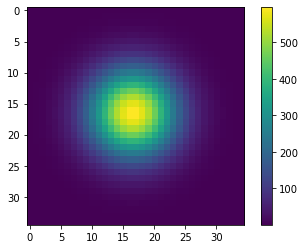

In [224]:
initial_guess = (res.max(),35//2,35//2,35//6,35//6,0,0)
plt.imshow(twoD_Gaussian((x, y), *initial_guess).reshape(35,35))
plt.colorbar()

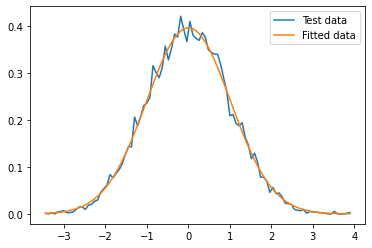

In [117]:
import numpy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define some test data which is close to Gaussian
data = numpy.random.normal(size=10000)

hist, bin_edges = numpy.histogram(data, density=True, bins=100)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

plt.plot(bin_centres, hist, label='Test data')
plt.plot(bin_centres, hist_fit, label='Fitted data')
plt.legend()

# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
# print 'Fitted mean = ', coeff[1]
# print 'Fitted standard deviation = ', coeff[2]

plt.show()


In [120]:
data.mean()

0.006652855358653693

In [119]:
%timeit curve_fit(gauss, bin_centres, hist, p0=p0)

480 µs ± 483 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


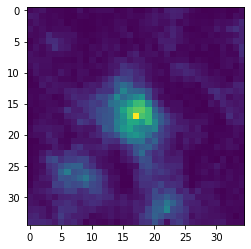

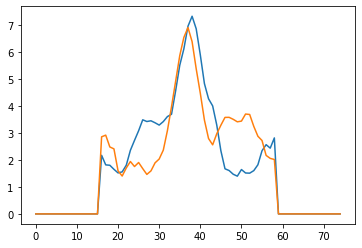

In [111]:
rx, ry = res.mean(axis=0), res.mean(axis=1)

hx = gauss(bin_centres, *coeff)
gauss(bin_centres, *coeff)
plt.plot(rx)
plt.plot(ry)